Let's see how scale factor vs pT would look if we had 2 distributions of the same underlying shape, but one is statistically smaller compared to the other.

We'll generate 2 samples with simple exponential shapes, and then calculate SF as a funciton of cutoff.

In [1]:
import ROOT
ROOT.TH1.SetDefaultSumw2()

Welcome to JupyROOT 6.18/04


In [34]:
import numpy as np
from array import array
from math import hypot

import scipy
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib
matplotlib.__version__

'3.1.1'

In [90]:
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['font.size'] = 16

In [178]:
# generate inclusive sample data
n_all = 10000
exp_data_all = scipy.stats.expon.rvs(size=n_all, loc=0, scale=150)

# generate high pt sample data
# There must be a better way, but the dumb way is to generate more inclusive data, 
# then mask off the low pt data
n_high_pt = 1000000
exp_data_high_pt = scipy.stats.expon.rvs(size=n_high_pt, loc=0, scale=150)
exp_data_high_pt = exp_data_high_pt[exp_data_high_pt>170]

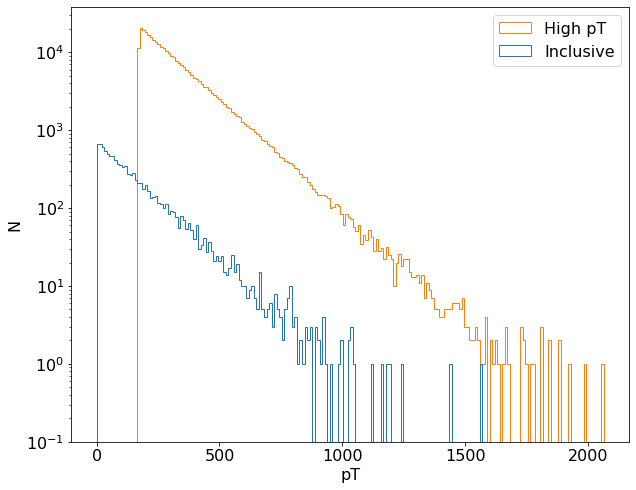

In [179]:
n, bins, _ = plt.hist([exp_data_all, exp_data_high_pt], bins=200, histtype='step', stacked=False, log=True, label=['Inclusive', 'High pT'])
plt.xlabel('pT');
plt.ylabel('N');
plt.legend();

We fill ROOT histograms, since I'm copying this from my main code, and it's just easier

In [180]:
h_inclusive = ROOT.TH1D("h_incl", "Inclusive", 200, 0, 1000)
for x in exp_data_all:
    h_inclusive.Fill(x)

h_high_pt = ROOT.TH1D("h_high_pt", "High-p_{T}", 200, 0, 1000)
for x in exp_data_high_pt:
    h_high_pt.Fill(x)

fudge = 0.5 # to simulate some prior scaling to xsec
h_high_pt.Scale(fudge * n_all / n_high_pt)

Warning in <TROOT::Append>: Replacing existing TH1: h_incl (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_high_pt (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


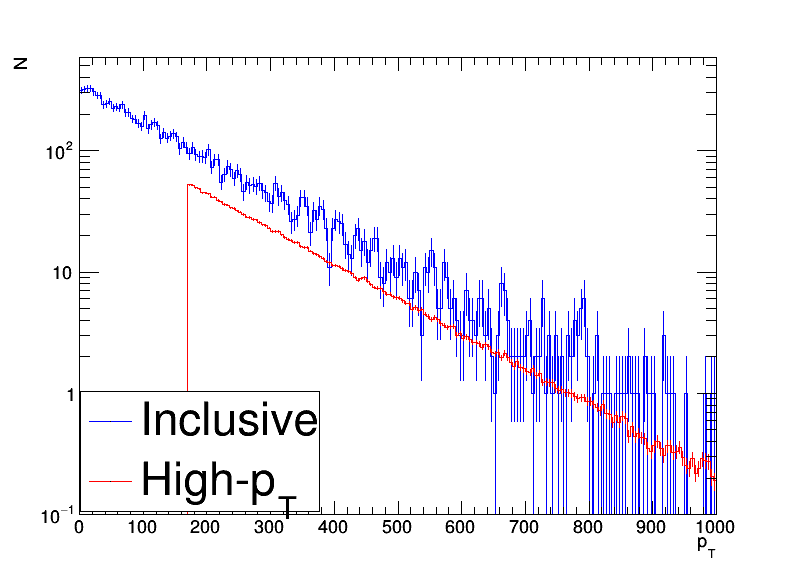

In [181]:
canv = ROOT.TCanvas("c", "", 800, 600)
canv.SetTicks(1, 1)
canv.SetLogy()
h_inclusive.SetLineColor(ROOT.kBlue)
h_high_pt.SetLineColor(ROOT.kRed)
hst = ROOT.THStack("hst", ";p_{T};N")
hst.Add(h_inclusive)
hst.Add(h_high_pt)
hst.Draw("NOSTACK HIST E0")
hst.SetMinimum(1E-1)
leg = canv.BuildLegend()
canv.Draw()

In [182]:
def calc_sf(inclusive_hist, high_pt_hist, pt_min, pt_max):
    """Calculate SF & its error using ratio of integrals between pt_min and pt_max"""
    xax = inclusive_hist.GetXaxis()
    first_bin = xax.FindBin(pt_min)
    last_bin = xax.FindBin(pt_max)
    inclusive_err = array('d', [0])  # do this way as expecting reference in C++
    high_pt_err = array('d', [0])
    inclusive_integral = inclusive_hist.IntegralAndError(first_bin, last_bin, inclusive_err)
    high_pt_integral = high_pt_hist.IntegralAndError(first_bin, last_bin, high_pt_err)
    ratio = (inclusive_integral / high_pt_integral)
    err = ratio * hypot((inclusive_err[0] / inclusive_integral), (high_pt_err[0] / high_pt_integral))
    return ratio, err

In [183]:
pt_mins = np.arange(200, 520, 20)
pt_max = 800
sfs = np.array([calc_sf(h_inclusive, h_high_pt, pt, pt_max) for pt in pt_mins])
print(pt_mins)
print(sfs)

[200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500]
[[1.93536467 0.03878568]
 [1.91596579 0.04131694]
 [1.92779849 0.04434611]
 [1.93443762 0.04756491]
 [1.93809777 0.05098497]
 [1.94519879 0.05474074]
 [1.92334666 0.05834888]
 [1.94946284 0.06293025]
 [1.90747694 0.06680679]
 [1.88905787 0.07132964]
 [1.89297638 0.07650619]
 [1.84671881 0.08112333]
 [1.84341174 0.08700927]
 [1.85732177 0.09412351]
 [1.85200405 0.10120107]
 [1.87314835 0.10975461]]


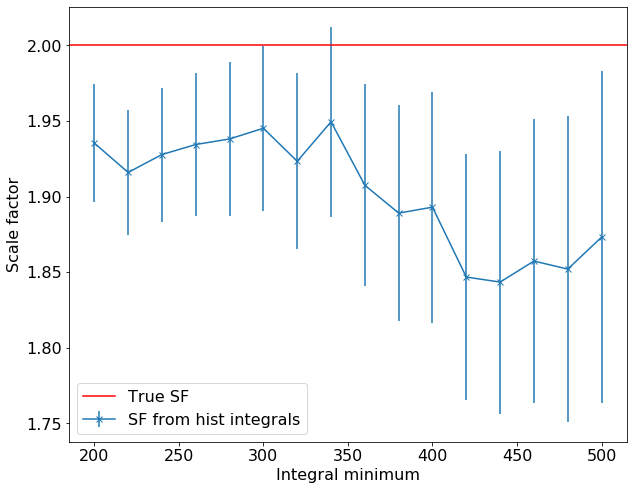

In [184]:
plt.errorbar(x=pt_mins, y=sfs[:,0], yerr=sfs[:,1], marker='x', label='SF from hist integrals');
plt.axhline(1/fudge, color='red', label='True SF');
plt.xlabel('Integral minimum');
plt.ylabel('Scale factor');
plt.legend();

With n_all = 1E5, n_high_pt = 1E6:

So we note that there is a ~2% error bar, and a lot of values tend to fall within ~2-3% of the true value. 

Interestingly, it doesn't do what I expected, which is to osciallate about the true value - I guess since we're using the integral, each point isn't statistically independent.

However, the variation here is not the ~10% I see in the potentially buggy samples. So it looks like statistics can't account for that.

With n_all = 1E4, n_high_pt = 1E6:

Now see a lot more bias away from true value, but not a million miles away